In [1]:
# Imports

########################################################################
# Python Standard Libraries
import os

########################################################################
# Numpy Library
import numpy as np # linear algebra

########################################################################
# Pandas Library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

########################################################################
# MATPLOT Library
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
%matplotlib inline

########################################################################
# SKLearn Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

########################################################################
# SCIPY Library
from scipy.stats import gaussian_kde
import scipy.stats as st

In [2]:
# Bilinear maps
def normalize(X, x_min=0, x_max=1):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

class BilinearMap:
    def __init__(self, target_n):
        self.target_cols = target_n

    def compute_coeff(self, X, y):
        try:
            #assert False, 'deliberate'
            Xt = np.transpose(X)
            #print ('X.shape:', X.shape, 'Xt.shape:', Xt.shape)
            Xp = np.dot(Xt, X)
            #print ('Xp.shape:', Xp.shape)
            Xpi = np.linalg.inv(Xp)
            #print ('Xpi.shape:', Xpi.shape)
            XpiXt = np.dot(Xpi, Xt)
            #print ('XpiXt.shape:', XpiXt.shape)
            coeff = np.dot(XpiXt, y)
            print ('coeff.shape:', coeff.shape)
        except Exception as e:
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            coeff = regressor.coef_
            print ('Exception:', e)

        #coeff = normalize(coeff)
        return coeff

    def fit_transform(self, X, y):
        target_rows = X.shape[1]
        actual_rows = X.shape[0]
        required_rows = target_rows * self.target_cols

        if actual_rows < required_rows:
            assert False, f"{required_rows} rows are required, {actual_rows} are provided"

        Y = []
        for i in range(self.target_cols):
            start = i * target_rows
            end = start + target_rows
            coeff = self.compute_coeff(X[start:end,:], y[start:end])
            Y.extend(coeff.tolist())
            print("coeff.shape:", coeff.shape, "Len y:", len(Y), 'Start:', start, 'End:', end)
        Y = np.array(Y)
        Y = Y.reshape(target_rows, self.target_cols)
        print("Y.shape:", Y.shape)
        Z = np.dot(X, Y)
        return Z

In [3]:
# Utility functions

########################################################################
# Walk through input files
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

########################################################################
# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

########################################################################
# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

########################################################################
# Dataset related functions
ds_nbaiot = '/kaggle/input/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()

In [4]:
# Visualization Functions

def plot_scatter_nbaiot_device(device_data, device_id, dim3=True):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    device_index = device_id-1
    print("scatter plot for", dn_nbaiot[device_index])
    (X, y) = device_data
    X_std = StandardScaler().fit_transform(X)

    #bmap = BilinearMap(target_n = 2)
    #X_bmap = bmap.fit_transform(X_std, y)

    bmap = PCA(n_components=2)
    X_bmap = bmap.fit_transform(X_std)

    print("X_bmap.shape:", X_bmap.shape, "X_std.shape:", X_std.shape)
    data_X = X_bmap[:,0]
    data_Y = X_bmap[:,1]
    data_Z = y
    data = np.column_stack((data_X, data_Y, data_Z))
    #if dim3:
    plot_3d_scatter(data, dn_nbaiot[device_index], 'PCA1', 'PCA2', 'Normal or Anomalous')
    #else:
    normal = mpatches.Patch(color='green', label='N')
    anomalous = mpatches.Patch(color='red', label='A')
    handles = [normal, anomalous]
    plot_2d_scatter(data, dn_nbaiot[device_index], 'PCA1', 'PCA2', handles)

def plot_surface_nbaiot_device(device_data, device_id):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    device_index = device_id-1
    print("scatter plot for", dn_nbaiot[device_index])
    (X, y) = device_data
    X_std = StandardScaler().fit_transform(X)

    #bmap = BilinearMap(target_n = 3)
    #X_bmap = bmap.fit_transform(X_std, y)

    bmap = PCA(n_components=2)
    X_bmap = bmap.fit_transform(X_std)

    print("X_bmap.shape:", X_bmap.shape, "X_std.shape:", X_std.shape)
    plot_3d_scatter_surface(X_bmap, dn_nbaiot[device_index], 'PCA1', 'PCA2', 'PCA3')

########################################################################
# Visualization related functions
def plot_3d_histogram(data):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X = data[:,0]
    Y = data[:,1]
    bins = 10
    hist, xedges, yedges = np.histogram2d(X, Y, bins=bins, range=[[0, bins*0.6], [0, bins*0.6]])

    # Construct arrays for the anchor positions of the bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    cmap = cm.get_cmap('cool')
    max_height = np.max(dz)
    min_height = np.min(dz)
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba)

    plt.show()

def plot_3d_surface(data, func):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]
    X, Y = np.meshgrid(X, Y)
    Z = func(X, Y)
    #print(Z.shape)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('surface');

def plot_3d_scatter(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    ax = plt.axes(projection='3d')
    ax.scatter(X, Y, Z, c = Z, cmap='RdYlGn')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

def plot_3d_scatter_trisurf(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    '''Xmin = int(np.floor(np.amin(X)))
    Xmax = int(np.ceil(np.amax(X)))
    Ymin = int(np.floor(np.amin(Y)))
    Ymax = int(np.ceil(np.amax(Y)))
    print("extrems:", Xmin, Xmax, Ymin, Ymax)
    sqmin = min(Xmin, Ymin)
    sqmax = max(Xmax, Ymax)
    print("sq min/max:", sqmin, sqmax)
    x = range(sqmin, sqmax)
    y = range(sqmin, sqmax)
    XX, YY = np.meshgrid(x, y)
    ZZ = np.zeros_like(XX)
    dim = X.shape[0]
    print('dim:', dim)
    Xi = X.astype(int)
    Yi = Y.astype(int)
    #print('Xi', Xi, 'Yi', Yi, 'X', X, 'Y', Y)
    for i in range(dim):
        row = Xi[i]
        col = Yi[i]
        val = 50 #Z[i]
        #print("row, col, val:", row, col, val)
        ZZ[row][col] += val
    '''
    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    #ax.plot_surface(XX, YY, ZZ)
    surf = ax.plot_trisurf(X - X.mean(), Y - Y.mean(), Z - Z.mean(), cmap=cm.jet, linewidth=0.1)
    fig.colorbar(surf)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(6))
    fig.tight_layout()
    plt.show()

def plot_3d_scatter_surface(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    #plot_3d_scatter_trisurf(data, title, xlabel, ylabel, zlabel)
    #plot_3d_scatter_fxy(data, title, xlabel, ylabel, zlabel)
    plot_3d_scatter_kde(data, title, xlabel, ylabel, zlabel)

def plot_3d_scatter_fxy(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]
    #Z = data[:,2]
    #XX, YY = np.meshgrid(X, Y)
    #ZZ = np.sinc((XX-20)/100*3.14) + np.sinc((YY-50)/100*3.14) #np.square(XX) + np.square(YY)
    XY = np.vstack([X,Y])
    Z = gaussian_kde(XY)(XY)

    # Sort the points by density, so that the densest points are plotted last
    idx = Z.argsort()
    x, y, z = X[idx], Y[idx], Z[idx]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #ax.scatter(x, y, z, c = z, cmap='jet')

    #surf = ax.plot_trisurf(x - x.mean(), y - y.mean(), z, cmap=cm.jet, linewidth=0.1)
    surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.1)
    ax.scatter(x,y,z, marker='.', s=10, c="black", alpha=0.5)
    #ax.view_init(elev=60, azim=-45)
    fig.colorbar(surf)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(6))
    fig.tight_layout()


    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

    return
    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.plot_surface(XX, YY, ZZ)
    plt.show()

def plot_3d_scatter_kde(data, title=None, xlabel=None, ylabel=None, zlabel=None):
    cols = data.shape[1]
    if cols < 2:
        assert False, 'The number of columns should be 2'
    X = data[:,0]
    Y = data[:,1]

    Xmin = int(np.floor(np.amin(X)))
    Xmax = int(np.ceil(np.amax(X)))
    Ymin = int(np.floor(np.amin(Y)))
    Ymax = int(np.ceil(np.amax(Y)))

    xmin = min(Xmin, Ymin)
    ymin = min(Xmin, Ymin)
    xmax = max(Xmax, Ymax)
    ymax = max(Xmax, Ymax)

    # Peform the kernel density estimate
    xx, yy = np.mgrid[Xmin:Xmax:100j, Ymin:Ymax:100j]
    #xx, yy = np.meshgrid(X, Y)
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([X, Y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure()
    #ax = fig.gca()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xlim(xmin, xmax)
    #ax.set_ylim(ymin, ymax)
    # Contourf plot
    #cfset = ax.contourf(xx, yy, f, cmap='Blues')
    ax.plot_surface(xx, yy, f - f.mean(), rstride=1, cstride=1, cmap='jet', edgecolor='none')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, colors='k')
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title)
    plt.show()

def plot_2d_scatter(data, title=None, xlabel=None, ylabel=None, handles=None):
    cols = data.shape[1]
    if cols < 3:
        assert False, 'The number of columns should be 3'
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]
    ax = plt.axes()
    scatter = ax.scatter(X, Y, c = ['green' if z > 0.5 else 'red' for z in Z], cmap='RdYlGn')
    ax.set_title(title);
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(handles=handles)
    plt.show()

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982
scatter plot for Danmini_Doorbell
X_bmap.shape: (1018298, 2) X_std.shape: (1018298, 115)


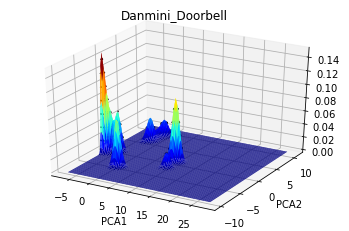

scatter plot for Danmini_Doorbell
X_bmap.shape: (1018298, 2) X_std.shape: (1018298, 115)


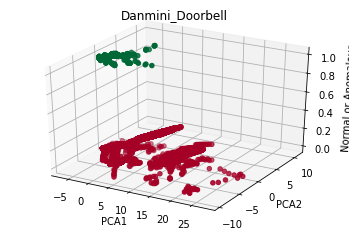

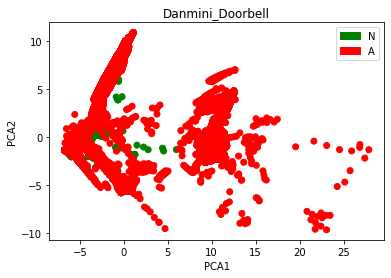

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368
scatter plot for Ecobee_Thermostat
X_bmap.shape: (835876, 2) X_std.shape: (835876, 115)


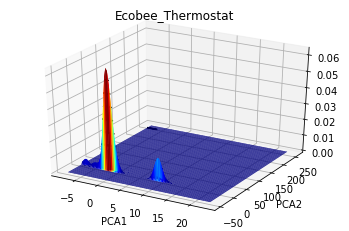

scatter plot for Ecobee_Thermostat
X_bmap.shape: (835876, 2) X_std.shape: (835876, 115)


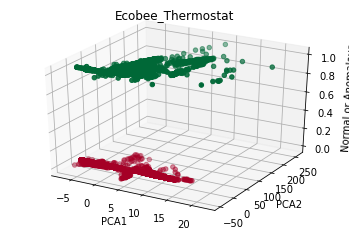

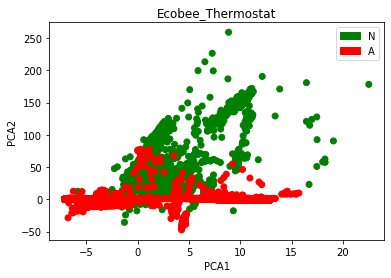

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933
scatter plot for Ennio_Doorbell
X_bmap.shape: (355500, 2) X_std.shape: (355500, 115)


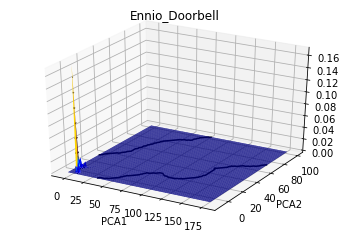

scatter plot for Ennio_Doorbell
X_bmap.shape: (355500, 2) X_std.shape: (355500, 115)


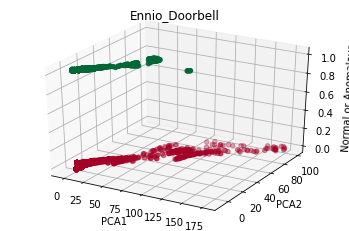

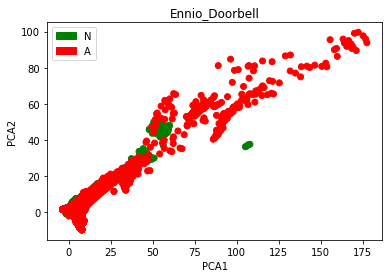

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808
scatter plot for Philips_B120N10_Baby_Monitor
X_bmap.shape: (1098677, 2) X_std.shape: (1098677, 115)


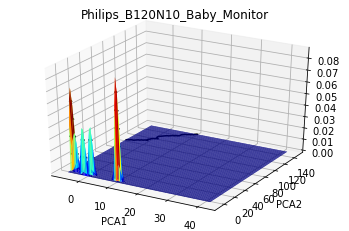

scatter plot for Philips_B120N10_Baby_Monitor
X_bmap.shape: (1098677, 2) X_std.shape: (1098677, 115)


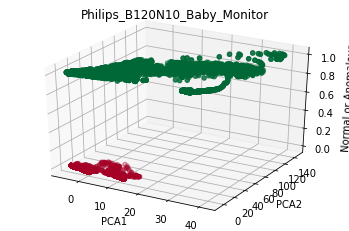

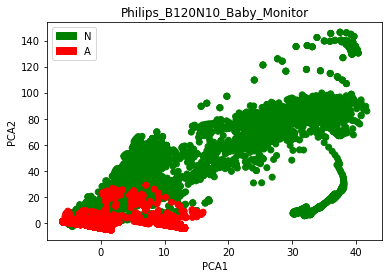

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681
scatter plot for Provision_PT_737E_Security_Camera
X_bmap.shape: (828260, 2) X_std.shape: (828260, 115)


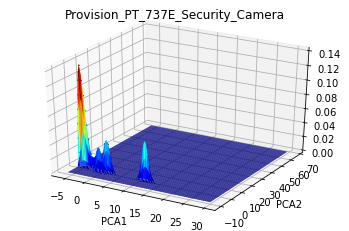

scatter plot for Provision_PT_737E_Security_Camera
X_bmap.shape: (828260, 2) X_std.shape: (828260, 115)


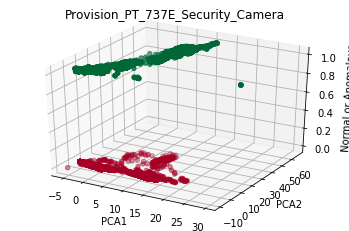

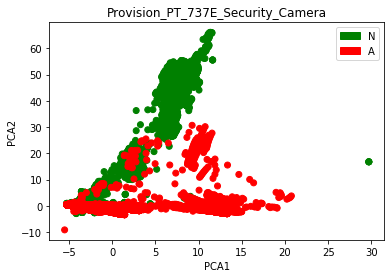

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785
scatter plot for Provision_PT_838_Security_Camera
X_bmap.shape: (836891, 2) X_std.shape: (836891, 115)


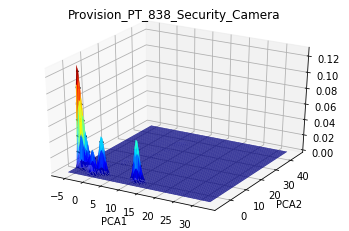

scatter plot for Provision_PT_838_Security_Camera
X_bmap.shape: (836891, 2) X_std.shape: (836891, 115)


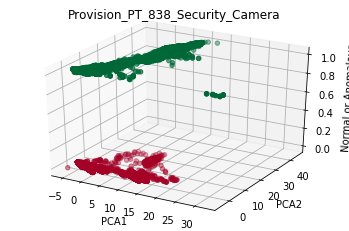

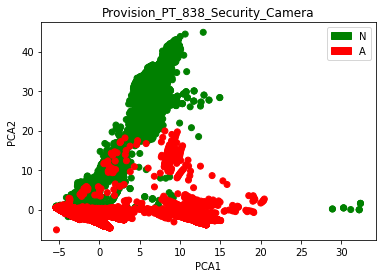

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617
scatter plot for Samsung_SNH_1011_N_Webcam
X_bmap.shape: (375222, 2) X_std.shape: (375222, 115)


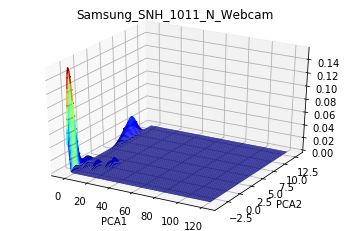

scatter plot for Samsung_SNH_1011_N_Webcam
X_bmap.shape: (375222, 2) X_std.shape: (375222, 115)


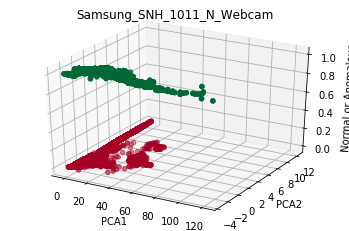

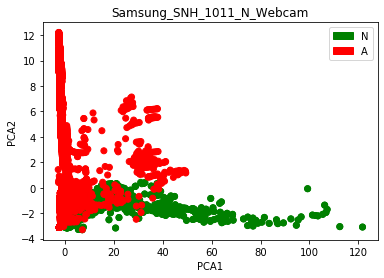

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244
scatter plot for SimpleHome_XCS7_1002_WHT_Security_Camera
X_bmap.shape: (863056, 2) X_std.shape: (863056, 115)


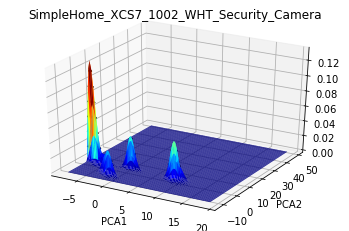

scatter plot for SimpleHome_XCS7_1002_WHT_Security_Camera
X_bmap.shape: (863056, 2) X_std.shape: (863056, 115)


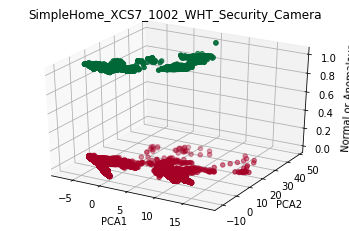

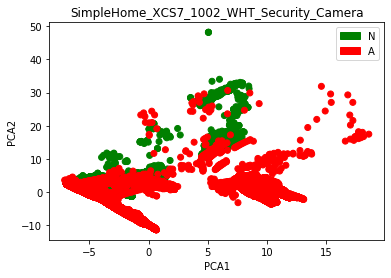

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436
scatter plot for SimpleHome_XCS7_1003_WHT_Security_Camera
X_bmap.shape: (850826, 2) X_std.shape: (850826, 115)


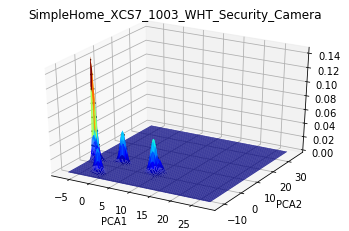

scatter plot for SimpleHome_XCS7_1003_WHT_Security_Camera
X_bmap.shape: (850826, 2) X_std.shape: (850826, 115)


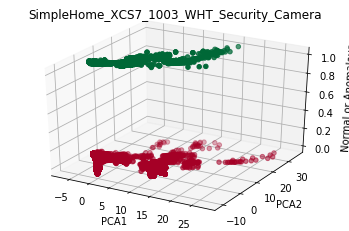

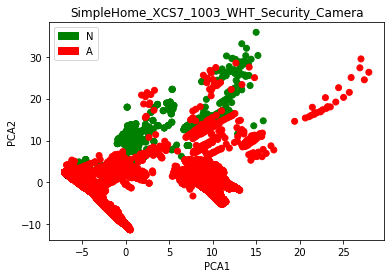

In [5]:
for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_data = get_nbaiot_device_data(device_id)
    plot_surface_nbaiot_device(device_data, device_id)
    plot_scatter_nbaiot_device(device_data, device_id, False)